In [ ]:
import numpy as np
import pandas as pd
import glob
import cv2
import math , mtcnn
import tensorflow as tf
from math import *
import keras.backend as K
from numpy import random
from keras_facenet import FaceNet
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score , roc_curve
from keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications.Mob import InceptionResNetV2
from tensorflow.keras.models import Model , load_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense , Flatten , Input ,BatchNormalization , concatenate , LeakyReLU

In [129]:
names = [
    'alexandro_dadario','aishwarya_rae','burak_deniz','chris_hemsworth','elon_musk','gayatri_bharadwaj',
    'hande_ercel','virat_kohli','ronaldo','sushant','samantha','hritik_roshan','priyanka_chopra',
    'nidhi_agarwal','kit_harington','kristen_stewart','nayantra','rasmika_mandhana','sundar_pichai',
    'zayn_malik','scarlet_johnson','amber_heard','sanjana_sanghi','mahesh_babu','vicky_kaushal',
    'priya','modiji','DeepikaPadukone','chris_evans','ana_de_armas'
]

In [130]:
len(names)

30

In [131]:
names_to_label = {}
labels_to_name = {}
faces = {}
imgshape = (160,160,3)
cnt = len(glob.glob('./New_data/**/*.jpg'))
X = np.zeros((cnt,160,160,3),dtype='float32')
y = np.zeros(cnt,dtype='uint8')

In [132]:
len(names)

30

In [133]:
batch =256
(batch,)+imgshape

(256, 160, 160, 3)

In [134]:
for i,name in enumerate(names):
    names_to_label[name] = i
    labels_to_name[i] = name

In [135]:
def readimage(url):
    img = cv2.imread(url)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = np.asarray(img).astype('float32')
    img = cv2.resize(img,(160,160))
    img = img/255.0
    return img
    

In [136]:
for i,img in enumerate(glob.glob('./New_data/**/*.jpg')):
    X[i] = readimage(img)
    name = img.split('/')[2]
    y[i] = names_to_label[name]

In [137]:
X_train ,  X_test , y_train, y_test = \
        train_test_split(X,y,shuffle=True,stratify=y,random_state=42,test_size=.15)

In [138]:
imgshape

(160, 160, 3)

In [139]:
def createbatch(batch_size = 256,split='train'):
    anchor = np.zeros((batch_size,)+imgshape)
    pos = np.zeros((batch_size,)+imgshape)
    neg = np.zeros((batch_size,)+imgshape)
    
    if split == 'train':
        dataX = X_train
        dataY = y_train
    else:
        dataX = X_test
        dataY = y_test
    
    for i in range(batch_size):
    
        random_idx = random.randint(0,dataX.shape[0]-1)
        y_random = dataY[random_idx]

        pos_idx = np.squeeze(np.where(dataY == y_random))
        neg_idx = np.squeeze(np.where(dataY != y_random))

        anchor[i] = dataX[random_idx]
        pos[i] = dataX[random.choice(pos_idx)]
        neg[i] = dataX[random.choice(neg_idx)]
    
    return [anchor, pos, neg]

In [140]:
res = createbatch(5)

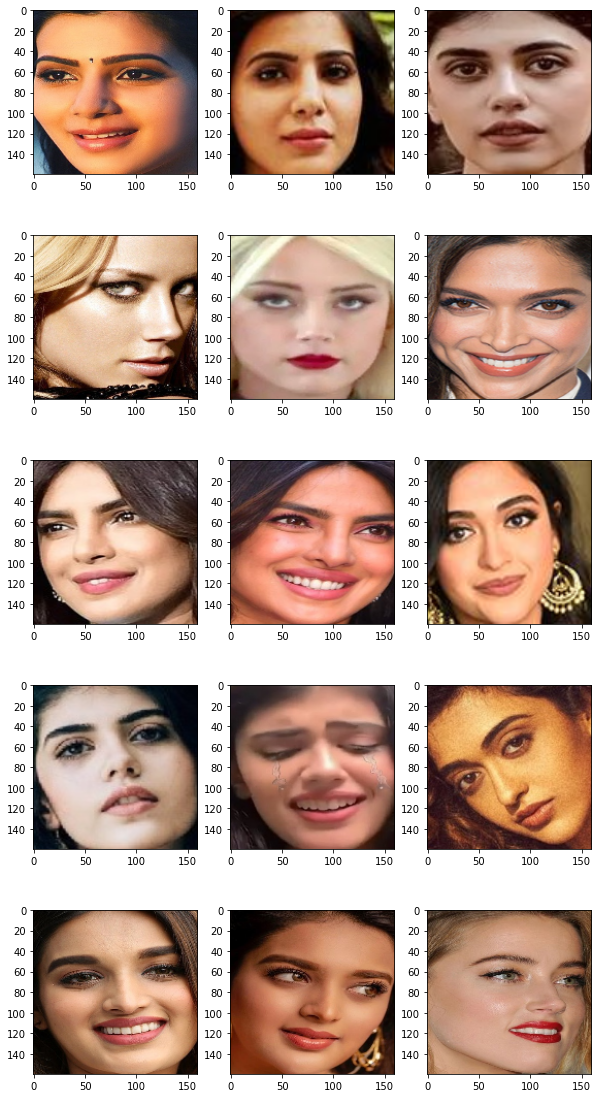

In [141]:
fig,ax = plt.subplots(5,3,figsize=(10,20))
for i in range(5): 
    ax[i][0].imshow(res[0][i])
    ax[i][1].imshow(res[1][i])    
    ax[i][2].imshow(res[2][i])    

In [142]:
facenet = FaceNet()

In [143]:
# mobilenet = MobileNetV2(include_top=False,weights='imagenet',input_shape=(160,160,3))
input = Input(imgshape)
x =  facenet.model.layers[-2].output
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(48,activation=LeakyReLU(alpha=0.1))(x)
out = Dense(32,activation='relu')(x)
embeddingModel = Model(facenet.model.input,out)

In [144]:
# embeddingModel.summary()

In [145]:
def euclideanDist(emb1,emb2):
    return K.sqrt(K.sum(K.square(emb1 - emb2), 1))

In [146]:
def create_hard_batch(batch_size, num_hard,split='train'):
    anchor = np.zeros((batch_size,)+imgshape)
    pos = np.zeros((batch_size,)+imgshape)
    neg = np.zeros((batch_size,)+imgshape)
    
    if split == 'train':
        dataX = X_train
        dataY = y_train
    else:
        dataX = X_test
        dataY = y_test
        
    hard_batches = [] 
    batch_losses = []
    
    rand_batches = []
    
    for i in range(batch_size):
        hard_batches.append(createbatch(1,split))
        
        a_emb = embeddingModel(hard_batches[i][0])
        p_emb = embeddingModel(hard_batches[i][1])
        n_emb = embeddingModel(hard_batches[i][2])
        
        batch_losses.append(euclideanDist(a_emb,p_emb) - euclideanDist(a_emb,p_emb))
        
    hard_batch_selections = [x for _, x in sorted(zip(batch_losses,hard_batches), key=lambda x: x[0])]
    hard_batches = hard_batch_selections[:num_hard]
        
    num_rand = batch_size - num_hard
        
    for i in range(num_rand):
        rand_batch = createbatch(1)
        rand_batches.append(rand_batch)
            
    result = hard_batches + rand_batches
    for i in range(batch_size):
        anchor[i] = result[i][0]
        pos[i]    = result[i][1]
        neg[i]    = result[i][2]

    return [anchor,pos,neg]

In [147]:
res= create_hard_batch(5,5)

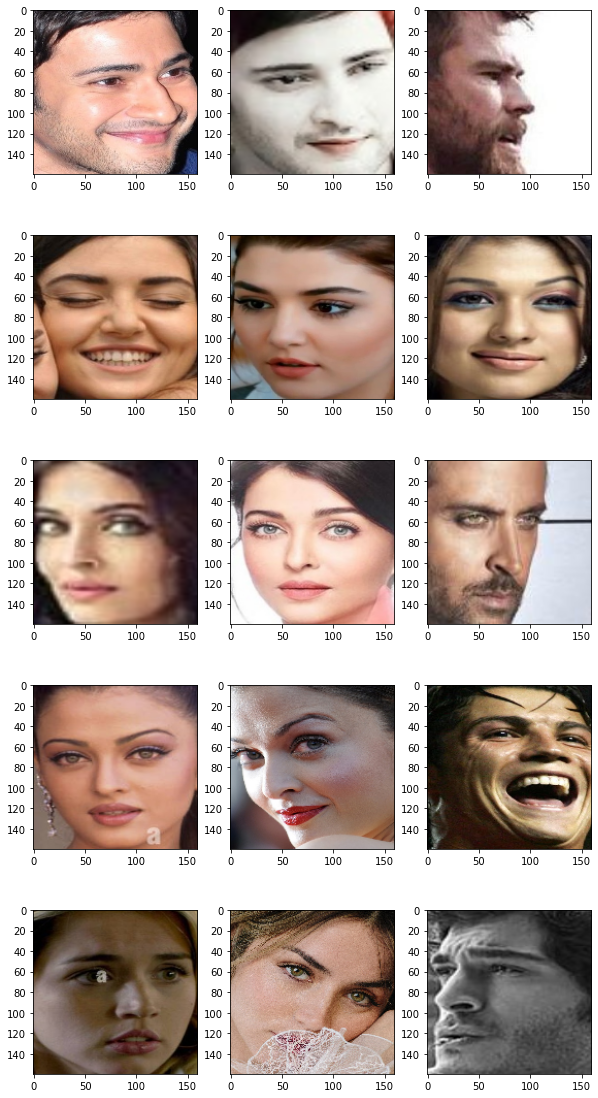

In [148]:
fig,ax = plt.subplots(5,3,figsize=(10,20))
for i in range(5):
    ax[i][0].imshow(res[0][i])
    ax[i][1].imshow(res[1][i])    
    ax[i][2].imshow(res[2][i])    

In [149]:
# embeddingModel.summary()

In [150]:
def create_SNN(embedding_model):

    input_anchor   = Input(imgshape)
    input_positive = Input(imgshape)
    input_negative = Input(imgshape)

    embedding_anchor = embedding_model(input_anchor)
    embedding_positive = embedding_model(input_positive)
    embedding_negative = embedding_model(input_negative)

    output = concatenate([embedding_anchor, embedding_positive, 
                                          embedding_negative], axis=1)

    siamese_net = Model([input_anchor, input_positive, input_negative], 
                                        output)
    siamese_net.summary()
    
    return siamese_net

In [151]:
def triplet_loss(y_true, y_pred):
    anchor, positive, negative = y_pred[:,:emb_size], y_pred[:,emb_size:2*emb_size],y_pred[:,2*emb_size:]
    positive_dist = tf.reduce_mean(tf.square(anchor - positive), axis=1)
    negative_dist = tf.reduce_mean(tf.square(anchor - negative), axis=1)
    return tf.maximum(positive_dist - negative_dist + alpha, 0.)

In [152]:
def data_generator(batch_size=256, num_hard=50, split="train"):
    while True:
        x = create_hard_batch(batch_size, num_hard, split)
        y = np.zeros((batch_size, 3*emb_size))
        yield x, y

In [153]:
batch_size = 20
epochs = 30
steps_per_epoch = int(X_train.shape[0]/batch_size)
val_steps = int(X_test.shape[0]/batch_size)
alpha = 0.005
num_hard = int(batch_size * 0.5) # Number of semi-hard triplet examples in the batch
emb_size = 32

In [154]:
siamese = create_SNN(embeddingModel)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_15 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_16 (InputLayer)          [(None, 160, 160, 3  0           []                               
                                )]                                                          

In [155]:
# optimiser_obj = Adam(lr = lr)
siamese.compile(loss=triplet_loss, optimizer= tf.optimizers.Adam(lr=0.00006))

/Users/paramkesarwani/miniforge3/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [156]:
history = siamese.fit(
    data_generator(batch_size, num_hard),
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    validation_data = data_generator(batch_size, num_hard, split="test"), 
    validation_steps = val_steps
)

Epoch 1/30


2022-08-13 09:37:07.126900: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - ETA: 0s - loss: 0.0086

2022-08-13 09:51:08.349410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


149/149 [==============================] - 973s 6s/step - loss: 0.0086 - val_loss: 0.0044
Epoch 2/30
149/149 [==============================] - 1037s 7s/step - loss: 0.0042 - val_loss: 0.0029
Epoch 3/30
149/149 [==============================] - 1090s 7s/step - loss: 0.0028 - val_loss: 0.0028
Epoch 4/30
149/149 [==============================] - 1005s 7s/step - loss: 0.0030 - val_loss: 0.0026
Epoch 5/30
149/149 [==============================] - 1247s 8s/step - loss: 0.0026 - val_loss: 0.0024
Epoch 6/30
149/149 [==============================] - 1005s 7s/step - loss: 0.0022 - val_loss: 0.0019
Epoch 7/30
149/149 [==============================] - 1010s 7s/step - loss: 0.0015 - val_loss: 0.0018
Epoch 8/30
149/149 [==============================] - 912s 6s/step - loss: 0.0014 - val_loss: 9.5530e-04
Epoch 9/30
149/149 [==============================] - 907s 6s/step - loss: 0.0020 - val_loss: 3.0388e-04
Epoch 10/30
149/149 [==============================] - 1053s 7s/step - loss: 0.0021 - va

In [160]:
embeddingModel.compiled_metrics == None

False

In [161]:
embeddingModel.compile(loss=None,optimizer= tf.optimizers.Adam(lr=0.00006))

In [162]:
embeddingModel.save('./NewEmbedding23234.h5')

In [275]:
embeds = dict({'name':[] ,'emb':[]})
for img in glob.glob('./test_purpose/*.jpg'):
    name = img.split('/')[2].split('.')[0]
    embeds['name'].append(name)
    
    image = readimage(img)
    emb = embeddingModel.predict(np.expand_dims(image,0))
    embeds['emb'].append(np.squeeze(emb))

1/1 [==============================] - 0s 29ms/step


In [276]:
def readImage(img):
    img = cv2.resize(img,(160,160))
    img = img.astype('float32')
    img = img/255.0
    return img

def cosine(emb1,emb2):
    return np.dot(emb1,emb2)/(np.linalg.norm(emb1) * np.linalg.norm(emb2) )

In [277]:
def predict(embeds,img):
    vector = None
    score = 0
    image = readImage(img)
    pred = np.squeeze(embeddingModel.predict(np.expand_dims(image,0)))
    
    for i in range(len(embeds['name'])):
        prob = cosine(embeds['emb'][i],pred)
        score = max(score,prob)
        if score == prob:
            vector = embeds['name'][i]
        if prob > 0.85:
            print(embeds['name'][i],prob)
    return vector,score
                   
        

In [284]:
img1 = getfaces('./amber-heard-celebrities-girls-hd-wallpaper-preview.jpeg')[0]
predict(embeds,img1)

2022-08-13 19:51:30.517871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 384ms/step


2022-08-13 19:51:30.925184: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 212ms/step


2022-08-13 19:51:33.160827: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


5/5 [==============================] - 1s 81ms/step


2022-08-13 19:51:34.219217: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 93ms/step
ana_de_armas 0.92971814
alexandro 0.8507286
scarletjonson 0.9062623
amber_heard 0.9333826
kristenStewart 0.9293699


('amber_heard', 0.9333826)

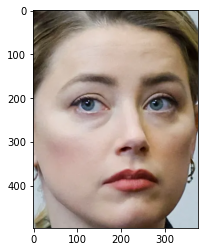

In [283]:
plt.imshow(img1)

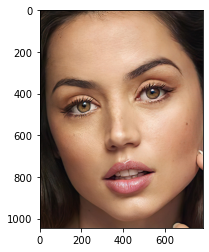

In [281]:
plt.imshow(plt.imread('./test_purpose/ana_de_armas.jpg'))